In [1]:
import sys; sys.path.insert(0, '..')

import gym
import sys
import torch
import tester
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Javascript

import pytorch_drl.models.rainbow_models as models

from pytorch_drl.algs.rainbow import Rainbow

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


## 1. Define Utils:

### 1.1 Plotting:

In [3]:
def mean_filter(arr, filter_len):
    arr = np.concatenate([[0]*(filter_len-1), arr])
    filter_arr = np.ones(filter_len)/filter_len
    arr = arr
    output = list()
    for i in range(filter_len-1, len(arr)):
        conv = np.sum(filter_arr * arr[i-filter_len+1:i+1])
        output.append(conv)
    return output

def plot(scores, n=None):
    if n is not None:
        scores = mean_filter(scores, n)
    clear_output(True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode')
    plt.show()

## 2. Create environment

In [4]:
env_name = "CartPole-v0"
env = gym.make(env_name)
env.seed(0)

state_size =  env.observation_space.shape[0]
action_size = env.action_space.n

print("State size:", state_size, "\nAction size:", action_size)

State size: 4 
Action size: 2


/home/selo/Envs/ml-agent_/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## 3. Define networks for different algorithms

In [6]:
def copy_network(network1, network2):
    network2.load_state_dict(network1.state_dict())

In [7]:
max_t = 1000
n_episodes = 2000
seed = 0+122
atoms = 51

print("xD")

rainbow_model1 = models.RainbowNetwork(state_size, action_size, atoms)
rainbow_model2 = models.RainbowNetwork(state_size, action_size, atoms)
copy_network(rainbow_model1, rainbow_model2)

dqn_model1 = models.DQNNetwork(state_size, action_size)
dqn_model2 = models.DQNNetwork(state_size, action_size)
copy_network(dqn_model1, dqn_model2)

ns_model1 = models.NoisyRainbowNetwork(state_size, action_size)
ns_model2 = models.NoisyRainbowNetwork(state_size, action_size)
copy_network(ns_model1, ns_model2)

dl_model1 = models.DuelingRainbowNetwork(state_size, action_size)
dl_model2 = models.DuelingRainbowNetwork(state_size, action_size)
copy_network(dl_model1, dl_model2)

nd_model1 = models.NoisyDuelingRainbowNetwork(state_size, action_size, seed=5)
nd_model2 = models.NoisyDuelingRainbowNetwork(state_size, action_size)
copy_network(nd_model1, nd_model2)

xD


## 4. Rainbow Test

Test the standard rainbow algorithm

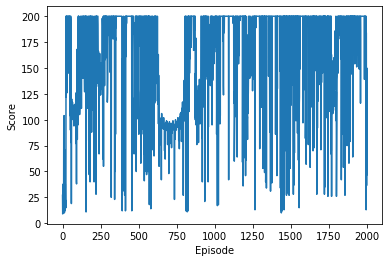

In [30]:
vmin = 0.0
vmax = 200.0

rainbow_model1 = models.RainbowNetwork(state_size, action_size, atoms)
rainbow_model2 = models.RainbowNetwork(state_size, action_size, atoms)
copy_network(rainbow_model1, rainbow_model2)

# init agent:
agent = Rainbow(state_size, action_size, seed, vmin=vmin, vmax=vmax, 
                 atoms=atoms,
                 distributional=True, #111
                 prioritized_replay=True,
                 ddqn=True,
                 n=3, #n-step
                 nstep=True,
                 noisy=True, # 111
                 model1=rainbow_model1,
                 model2=rainbow_model2,
                 gamma = 0.99,
                 lr = None,
                 n_replay = 1,
                 buf_size = int(1e3),
                 batch_size = 32,
                 is_beta = 1, #importance sampling
                 pr_alpha = 0.2,
                 tau = 1e-3,
                 device = device,
                 beta_horz = 20000 #beta horizon (n_of_steps)
               )


# train the agent
scores = tester.train_agent(agent, env, max_t, n_episodes, "rainbow", render_freq=1000, log=True)
# plot the training:
plot(scores)

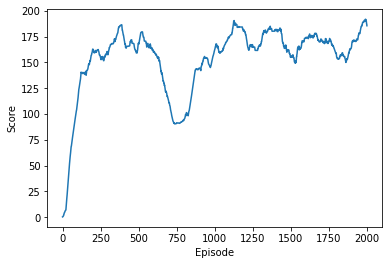

In [39]:
plot(scores, 100)

### 4.1 Trained Agent Demonstration

In [40]:
tester.test_agent(agent, env, max_t, render=True, num_of_episodes=5, log=True)

200.0
200.0
200.0
200.0
200.0


## 5. DQN Test

Test the DQN algorithm with Double Q Learning

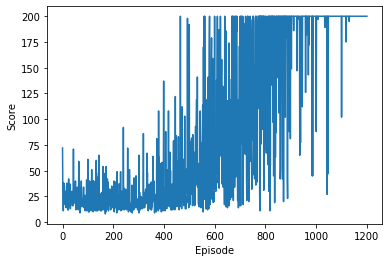

In [43]:
# init agent:

dqn_model1 = models.DQNNetwork(state_size, action_size)
dqn_model2 = models.DQNNetwork(state_size, action_size)
copy_network(dqn_model1, dqn_model2)

dqn_agent = Rainbow(state_size, 
                     action_size, 
                     seed,
                     ddqn=True,
                     model1=dqn_model1,
                     model2=dqn_model2,
                     gamma = 0.99,
                     lr = 1e-4,
                     n_replay = 4,
                     buf_size = int(1e5),
                     batch_size = 64,
                     tau = 1e-3,
                     device = device)
# train the agent
dqn_scores = tester.train_agent(dqn_agent, env, max_t, n_episodes, "dqn", render_freq=1000, log=True)
# plot the training:
plot(dqn_scores, n=50)

### 5.1 Trained Agent Demonstration

In [16]:
tester.test_agent(dqn_agent, env, max_t, render=True, num_of_episodes=5, log=True)

200.0
200.0
200.0
200.0
200.0


## 6. QR - DQN Test

Test the DQN algorithm with quantized regression

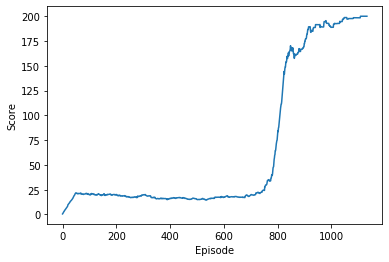

In [76]:
n_quants = 51
qrdqn_model1 = models.QRDQNNetwork(state_size, action_size, n_quants)
qrdqn_model2 = models.QRDQNNetwork(state_size, action_size, n_quants)
copy_network(rainbow_model1, rainbow_model2)

qr_dqn_agent = Rainbow(state_size, 
                     action_size, 
                     seed,
                     ddqn=True,
                     n_quants=n_quants,
                     quantile_regression=True,
                     model1=qrdqn_model1,
                     model2=qrdqn_model2,
                     gamma = 0.99,
                     lr = 1e-4,
                     n_replay = 4,
                     buf_size = int(1e5),
                     batch_size = 64,
                     tau = 1e-3,
                     device = device)
# train the agent
qr_dqn_scores = tester.train_agent(qr_dqn_agent, env, max_t, n_episodes, "qr_dqn", render_freq=1000, log=True)
# plot the training:
plot(qr_dqn_scores, n=50)

### 6.1 Trained Agent Demonstration

In [77]:
tester.test_agent(qr_dqn_agent, env, max_t, render=True, num_of_episodes=5, log=True)

200.0
200.0
200.0
200.0
200.0


## 7. Rainbow with Quantile Regression Test

Test the Rainbow algorithm with quantized regression instead for distributional approach (C51)

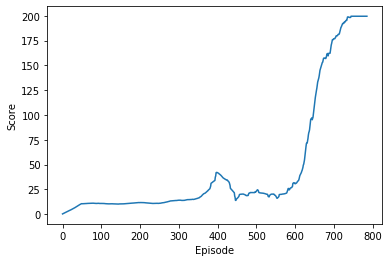

In [114]:
n_quants = 51

qr_rainbow_model1 = models.QRRainbowNetwork(state_size, action_size, atoms)
qr_rainbow_model2 = models.QRRainbowNetwork(state_size, action_size, atoms)
copy_network(rainbow_model1, rainbow_model2)

# init agent:
qr_rainbow_agent = Rainbow(state_size, action_size, seed,
                 prioritized_replay=True,
                 ddqn=True,
                 n_quants=n_quants,
                 quantile_regression=True,
                 n=3, #n-step
                 nstep=True,
                 noisy=True, # 111
                 model1=qr_rainbow_model1,
                 model2=qr_rainbow_model1,
                 gamma = 0.99,
                 lr = None,
                 n_replay = 1,
                 buf_size = int(1e3),
                 batch_size = 32,
                 is_beta = 1, #importance sampling
                 pr_alpha = 0.0,
                 tau = 1e-3,
                 device = device,
                 beta_horz = 20000 #beta horizon (n_of_steps)
               )


# train the agent
qr_rainbow_scores = tester.train_agent(qr_rainbow_agent, env, max_t, n_episodes, "qr_rainbow", render_freq=1000, log=True)
# plot the training:
plot(qr_rainbow_scores, 50)

### 7.1 Trained Agent Demonstration

In [115]:
tester.test_agent(qr_rainbow_agent, env, max_t, render=True, num_of_episodes=5, log=True)

200.0
200.0
200.0
200.0
200.0


### Lunar-Lander

In [10]:
env_name = "LunarLander-v2"
env = gym.make(env_name)
env.seed(0)

state_size =  env.observation_space.shape[0]
action_size = env.action_space.n

print("State size:", state_size, "\nAction size:", action_size)

State size: 8 
Action size: 4
